In [ ]:
import time
import os 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt

import scipy.misc
import numpy as np
import numpy.random as npr

# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def get_one_hot(ind, vec_size):
  vec = np.zeros(vec_size)
  vec[ind] = 1

  return vec

def load_input_data():
  # load input data and separate into training/test data
  df = pd.read_pickle('puzzle_solver_final.pkl')
  
  # note for puzzle solving task, the output is
  # a 3760 dimensional vector representing all possible moves in chess 
  df['target'] = df.apply(lambda x: get_one_hot(x['target'], 3760), axis=1)

  X = list(df['vectorized'])
  y = list(df['target'])

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
  
  return (np.array(X_train), np.array(y_train)), (np.array(X_test), np.array(y_test))

In [ ]:
batch_size = 64  #@param {type:"integer"}

# set up DataLoader for batch sampling
(x_train, y_train), (x_test, y_test) = load_input_data()
x_train, y_train, x_test, y_test = torch.FloatTensor(x_train).cuda(), torch.FloatTensor(y_train).cuda(), torch.FloatTensor(x_test).cuda(), torch.FloatTensor(y_test).cuda()

train_ds = data_utils.TensorDataset(x_train, y_train)
train_loader = data_utils.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

test_ds = data_utils.TensorDataset(x_test, y_test)
test_loader = data_utils.DataLoader(test_ds, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
class MultiMaskNet(nn.Module): # Pretraining
    """
    A network to predict masked squares
    
    Input is 15 x 8 x 8
      - channels 1 to 12 represent the piece location (excluding masked pieces)
      - channels 13 to 14 represent move that was played
      - channel 15 represents the mask
    
    Architecture:
      - Feed the first 14 channels through 4 CNN layers
      - Feed the 15th channel through 1 CNN layer
      - Concatenate the output of both along the channel dimension
      - Feed the result through a CNN layer that reduces the 
        number of channels to 12, giving the logits on which we apply
        cross entropy loss

    * Note this structure eliminates dependency on the mask channel for 
      the first 4 CNN layers, allowing us to better apply the representations 
      to downstream tasks
    """
    
    def __init__(self, kernel, num_in_channels):
        super().__init__()

        padding = kernel // 2

        C = 64

        self.block_1 = nn.Sequential(
            nn.Conv2d(num_in_channels-1, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_4 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )

        self.mask_encoder = nn.Conv2d(1, C, kernel_size=kernel, padding=padding)

        self.block_5 = nn.Conv2d(2 * C, 12, kernel_size=1, padding=0)

    def forward(self, x):
        x, mask = x[:, :-1], x[:, -1:]

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)

        encoded_mask = self.mask_encoder(mask)
        x = torch.cat([x, encoded_mask], dim=1)
        
        logits = self.block_5(x)
        
        return logits

    def get_initial(self, x):
        """ For using pretrained layers.
        """
        x, mask = x[:, :-1], x[:, -1:]

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)

        return x

In [ ]:
class MaskedForkNet(nn.Module): # Transfer / Fine tune
    """
    A network to find moves that lead to a fork in chess

    Input is 14 x 8 x 8
      - channels 1 to 12 represent the piece location
      - channels 13 to 14 represent move that was played
    
    Architecture:
      - Feed input through first 4 layers of the pretrained network (MultiMaskNet)
      - Feed the output through a fifth and sixth (random initialized) CNN layers 
      - Apply average pooling + a linear to end up with a 3760 dimensional logit 
        on which we apply cross entropy loss
    """

    def __init__(self, kernel, num_in_channels, masknet, freeze_masknet):
        super().__init__()
    
        self.masknet = masknet
        self.freeze_masknet = freeze_masknet
        
        padding = kernel // 2

        C = 64
        
        self.block_5 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )

        self.block_6 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )

        self.lin = nn.Linear(C, 3760)

    def forward(self, x):
        if self.freeze_masknet:
          self.masknet.eval()

        x = self.masknet.get_initial(x)
        
        if self.freeze_masknet:
          x = x.detach() 

        x = self.block_5(x)
        x = self.block_6(x)
        x = torch.mean(x, dim=(2, 3), keepdim=False)
        logits = self.lin(x)
        
        return logits

In [ ]:
class ForkNet(nn.Module): # End to End
    """
    A network to find moves that lead to a fork in chess

    Here we use the same architecture as MaskedForkNet,
    but train end to end with random initialization
    """

    def __init__(self, kernel, num_in_channels):
        super().__init__()

        padding = kernel // 2

        C = 64

        self.block_1 = nn.Sequential(
            nn.Conv2d(num_in_channels-1, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )
        self.block_4 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )

        self.block_5 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )

        self.block_6 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(C),
            nn.ReLU()
        )

        self.lin = nn.Linear(C, 3760)

    def forward(self, x):
        x, mask = x[:, :-1], x[:, -1:]

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        
        x = self.block_5(x)
        x = self.block_6(x)
        x = torch.mean(x, dim=(2, 3), keepdim=False)
        logits = self.lin(x)
        
        return logits

In [ ]:
def run_validation_step(
    cnn,
    plotpath=None
):
    correct = 0.0
    total = 0.0
    losses = []

    for i, (boards, labels) in enumerate(test_loader):
        outputs = cnn(boards)

        val_loss = F.cross_entropy(outputs, labels.type(torch.FloatTensor).cuda())
        losses.append(val_loss.data.item())

        predicted = torch.argmax(outputs, dim=1)
        
        total += labels.size(0) 
        correct += (predicted == torch.argmax(labels, dim=1)).sum()

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


def train(args, cnn=None):
    # set the maximum number of threads
    torch.set_num_threads(5)
    # random seed
    npr.seed(args.seed)

    # save directory
    save_dir = "outputs/" + args.experiment_name

    num_in_channels = 15
    if args.pretrained is not None:
      pretrained_model = torch.load(args.pretrained)

      if cnn is None:
        Net = globals()[args.model]
        cnn = Net(args.kernel, num_in_channels, pretrained_model, args.freeze_pretrained)
    
    else:
      if cnn is None:
        Net = globals()[args.model]
        cnn = Net(args.kernel, num_in_channels)

    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    
    train_accs = []
    valid_accs = []
    
    for epoch in range(args.epochs):
        # train the model
        cnn.train()
        losses = []
        correct = 0.0
        total = 0.0
        for i, (boards, labels) in enumerate(train_loader):
            # forward + backward + optimize
            optimizer.zero_grad()
            outputs = cnn(boards)

            loss = F.cross_entropy(outputs, labels.type(torch.FloatTensor).cuda())
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

            predicted = torch.argmax(outputs, dim=1)

            total += labels.size(0) 
            correct += (predicted == torch.argmax(labels, dim=1)).sum()

        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        train_acc = 100 * correct / total
        train_accs.append(train_acc.data.item())
        time_elapsed = time.time() - start
        print(
            "Epoch [%d/%d], Loss: %.4f, Time (s): %d"
            % (epoch + 1, args.epochs, avg_loss, time_elapsed)
        )

        # evaluate the model
        cnn.eval()
        val_loss, val_acc = run_validation_step(
            cnn,
            save_dir + "/test_%d.png" % epoch
        )

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc.data.item())
        print(
            "Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f"
            % (epoch + 1, args.epochs, val_loss, val_acc, time_elapsed)
        )

    # plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/training_curve.png")

    plt.figure()
    plt.plot(train_accs, "ro-", label="Train")
    plt.plot(valid_accs, "go-", label="Validation")
    plt.legend()
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/accuracy_curve.png")

    if args.checkpoint:
        print("Saving model...")
        torch.save(cnn.state_dict(), args.checkpoint)

    return cnn

Beginning training ...
Epoch [1/8], Loss: 5.7649, Time (s): 9
Epoch [1/8], Val Loss: 4.9929, Val Acc: 17.6%, Time(s): 11.23
Epoch [2/8], Loss: 4.4625, Time (s): 18
Epoch [2/8], Val Loss: 4.2133, Val Acc: 27.5%, Time(s): 20.04
Epoch [3/8], Loss: 3.5492, Time (s): 27
Epoch [3/8], Val Loss: 3.6380, Val Acc: 36.0%, Time(s): 28.74
Epoch [4/8], Loss: 2.8566, Time (s): 36
Epoch [4/8], Val Loss: 3.3206, Val Acc: 42.2%, Time(s): 37.54
Epoch [5/8], Loss: 2.3620, Time (s): 45
Epoch [5/8], Val Loss: 3.1727, Val Acc: 44.1%, Time(s): 46.42
Epoch [6/8], Loss: 1.9906, Time (s): 53
Epoch [6/8], Val Loss: 3.2372, Val Acc: 45.1%, Time(s): 55.24
Epoch [7/8], Loss: 1.6776, Time (s): 62
Epoch [7/8], Val Loss: 3.2931, Val Acc: 45.8%, Time(s): 64.08
Epoch [8/8], Loss: 1.4187, Time (s): 72
Epoch [8/8], Val Loss: 3.4001, Val Acc: 44.7%, Time(s): 73.80


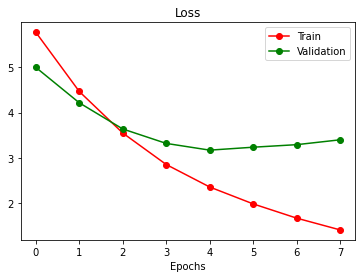

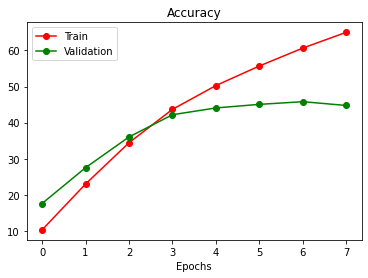

In [ ]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "model": "MaskedForkNet",
    "kernel": 5,
    "learn_rate": 0.01, 
    "epochs": 8,
    "seed": 0,
    "plot": True,
    "experiment_name": "puzzle_solver_1",
    "freeze_pretrained" : False,
    "pretrained": '../models/masknet_25.pt'
}
args.update(args_dict)
cnn = train(args)